# Data Science Online
## Part 8: Exploratory Data Analysis (Bike Sharing case study)

<br/>

<div class="container">
    <div style="float:left;width:40%">
	    <img src="images/bikeshare_sun.jpg">
    </div>
    <div style="float:left;width:40%">
	    <img src="images/bikeshare_snow.PNG">
    </div>
</div>

### Table of Contents

[Case Study: Bike Sharing](#sectioncase)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   [The Test-Train Split](#subsection0)


1 - [Exploratory Data Analysis](#section1)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a - [Data Types and Summary Statistics](#subsection1a)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b - [Visualizations Continued: Numerical Data and Widgets](#subsection1b)


2 - [Linear Regression Model](#section2)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a - [Explanatory and Response Variables](#subsection2a)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b - [Finding $\beta$](#subsection2b)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c - [Evaluating the Model](#subsection2c)


3 - [Challenge: Improve the Model](#section3)<br>


In [21]:
# run this cell to import some necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from scripts.exec_ed_scripts import *

import ipywidgets as widgets
from scipy.linalg import lstsq
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Case Study: Capital Bike Share <a id= "sectioncase"></a>

Bike-sharing systems have become increasingly popular worldwide as environmentally-friendly solutions to traffic congestion, inadequate public transit, and the "last-mile" problem. Capital Bikeshare runs one such system in the Washington, D.C. metropolitan area.

The Capital Bikeshare system comprises docks of bikes, strategically placed across the area, that can be unlocked by *registered* users who have signed up for a monthly or yearly plan or by *casual* users who pay by the hour or day. They collect data on the number of casual and registered users per hour and per day.

Let's say that Capital Bikeshare is interested in a **prediction** problem: predicting how many riders they can expect to have on a given day. [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) has combined the bike sharing data with information about weather conditions and holidays to try to answer this question.

In this notebook, we'll walk through the steps a data scientist would take to answer this question.

###  The Test-Train Split <a id="subsection0"> </a>

When we train a model on a data set, we run the risk of [**over-fitting**](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html). Over-fitting happens when a model becomes so complex that it makes very accurate predictions for the data it was trained on, but it can't generalize to make good predictions on new data.

Over- and under-fitting are most easily explained visually. The [Scikit-Learn machine learning library](http://scikit-learn.org) has a good example:

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png"/>

The linear model on the left is **under-fitting**: we can see that there is a lot of vertical distance (the *error*) between the actual samples (the dots) and the prediction (the blue line). The 15-degree model on the right is over-fitting: there's almost no error, but the model is so complex it is unlikely to generalize to new data. Our goal is to get the model in the middle: reduce the error as much as possible while keeping the complexity low.

We can reduce the risk of overfitting by using a **test-train split**. 

1. Randomly divide our data set into two smaller sets: one for training and one for testing
2. Train the data on the training set, changing our model along the way to increase accuracy
3. Test the data's predictions using the test set.

<div class="alert alert-info">

**Over-fitting to the test set**
By using the test set over and over to check the predictive accuracy of different models, we run the risk of over-fitting to the test set as well. In the real world, data scientists get around this by also using a **validation set**- a portion of training data that the model isn't trained on, used to find optimal *hyperparameters* for the model (parameters that are set before the model is trained). Because we're using only limited hyperparameters, and because our model is for educational purposes, we'll only use training and test sets.

</div>

Our bike data has been divided ahead of time into test and training sets. Run the next cell to load the training and test data.

In [29]:
# run this cell to load the data
bikes = pd.read_csv("data/day_renamed_dso.csv", index_col=0)
bikes["date"] = pd.to_datetime(bikes["date"])
bikes.head()

,date,season,year,month,is holiday,week day,is work day,weather,temp,felt temp,humidity,windspeed,casual riders,registered riders,total riders
instant,,,,,,,,,,,,,,,
1,2011-01-01,spring,2011,1,no,saturday,no,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,spring,2011,1,no,sunday,no,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,spring,2011,1,no,monday,yes,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,spring,2011,1,no,tuesday,yes,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,spring,2011,1,no,wednesday,yes,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [30]:
np.random.seed(28)

In [31]:
# run this cell to load the data
bike_train, bike_test = train_test_split(bikes, test_size=0.2, 
                                           train_size=0.8)

In [32]:
bikes_test.shape

(147, 16)

<div class="class alert-warning">**QUESTION:** Data is often expensive to collect, and having a good predictive model can be the difference between success and ruin. Given these factors, the decision of how much data to set aside for testing and validation is very personal.

What are some reasons for putting a larger portion of data into the training set? What are some risks?
</div>

**ANSWER:**

## 1. Exploratory Data Analysis (EDA) <a id= "section1"></a>

> "It is important to understand what you CAN DO before you learn to measure how WELL you seem to have done it." -John W. Tukey, *Exploratory Data Analysis*

**Exploratory Data Analysis (EDA)** is the process of 'looking at data to see what it seems to say'. EDA is an essential first step toward answering any research question. Through this process, we hope to accomplish several things:
- learn about the overall 'shape' of the data: structure, organization, ranges of values
- assess what assumptions we can make about the data as a basis for later statistical inference
- figure out the appropriate tools and techniques for analysis 
- tentatively create testable, appropriate hypotheses or models

We will do this by looking at summary statistics and visualizations of the different variables.

### 1a. Data Types and Summary Statistics <a id= "subsection1a"></a>

Before we even know how to visualize the data, we need to know what types of data we're working with. Run the following cell to show our bike sharing training data.

In [15]:
bike_train.head()

,date,season,year,month,is holiday,week day,is work day,weather,temp,felt temp,humidity,windspeed,casual riders,registered riders,total riders
instant,,,,,,,,,,,,,,,
216,2011-08-04,fall,2011,8,no,thursday,yes,2,0.710000,0.664788,0.757500,0.197150,799,3777,4576
571,2012-07-24,fall,2012,7,no,tuesday,yes,1,0.750833,0.706450,0.655000,0.211454,1140,6452,7592
12,2011-01-12,spring,2011,1,no,wednesday,yes,1,0.172727,0.160473,0.599545,0.304627,25,1137,1162
182,2011-07-01,fall,2011,7,no,friday,yes,1,0.722500,0.652162,0.396250,0.102608,1246,4116,5362
304,2011-10-31,winter,2011,10,no,monday,yes,1,0.340000,0.356063,0.703333,0.106350,362,3307,3669


A few of the less straight-forward columns can be described as follows:
- **instant**: record index
- **is 2012** : 1 if the date is in 2012, 0 if the date is in 2011
- **is holiday** : 1 if day is a holiday, 0 otherwise
- **is work day** : 1 if day is not a weekend or holiday, otherwise 0
- **weather** :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- **felt temp**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- **humidity**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **total riders**: count of total rental bikes (casual + registered)

<div class="class alert-warning">
<b>QUESTION:</b> Which of the variables are numerical and which are categorical? Intuitively, which do you think would be useful for predicting the number of riders on a given day? Would you choose different variables depending on if you wanted to predict casual versus registered rider counts?
</div>

**ANSWER:** 

#### Summary Statistics
It can also be useful to know some *summary statistics* about the different variables: things like the minimum, maximum, and average. Earlier, we learned how to do this on individual columns using functions like `min`, `max`, and `np.average`.

Thankfully, we can generate a variety of summary statistics for many variables at the same time using a function called `describe`. `describe` works on a variety of table called a dataframe. Run the following cell to convert our bike data table to a dataframe, then generate the summary statistics.

In [16]:
# generate summary statistics
bike_train.describe()

,year,month,weather,temp,felt temp,humidity,windspeed,casual riders,registered riders,total riders
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,2011.496575,6.565068,1.400685,0.498816,0.476885,0.630011,0.192425,841.597603,3676.628425,4518.226027
std,0.500417,3.436642,0.543541,0.182598,0.162743,0.139491,0.076869,676.951334,1574.176722,1949.685179
min,2011.000000,1.000000,1.000000,0.059130,0.079070,0.275833,0.045404,2.000000,20.000000,22.000000
25%,2011.000000,4.000000,1.000000,0.342500,0.340898,0.519063,0.135580,316.750000,2507.500000,3123.250000
50%,2011.000000,7.000000,1.000000,0.502989,0.490329,0.625625,0.182527,723.500000,3683.000000,4566.500000
75%,2012.000000,10.000000,2.000000,0.656875,0.611118,0.732604,0.235242,1118.500000,4815.500000,5989.750000
max,2012.000000,12.000000,3.000000,0.861667,0.840896,0.972500,0.441563,3410.000000,6946.000000,8555.000000


<div class="class alert-warning">
<b>QUESTION:</b> Looking at these statistics as data scientists, we're interested in a few things in particular:
<ul>
    <li>are there any values missing (e.g. days for which some data was not collected)?</li>
    <li>what kinds of values does each variable take?</li>
    <li>are there any extreme values that might throw off our analysis?</li>
    </ul>

Using the summary table, answer these questions below.
</div>

**ANSWER:**


### 1b. Visualization Continued: Numerical Data and Widgets <a id= "subsection1b"></a>
So far, we've worked largely with categorical variables, which we visualized with bar graphs. The bike sharing data contains several *numerical* variables, which will necessitate different visualizations.

You've previously used the `hist` function to visualize the distribution of a numerical variable. The following cell creates a **widget** that will make different histograms based on the variable you choose in the drop box. Run the cell to created the widget (don't worry too much about the details of the code).

In [17]:
# create a widget to plot and compare different histograms
explanatory_slider = widgets.Dropdown(options=["temp", "felt temp", "humidity", "windspeed"])
display(widgets.interactive(lambda x: bike_train.hist(x, bins=30), x=explanatory_slider))

interactive(children=(Dropdown(description='x', options=('temp', 'felt temp', 'humidity', 'windspeed'), value=…

<div class="class alert-warning">
<b>QUESTION:</b> Describe the distributions of the different variables. Are they normally distributed? Are any of them <i>skewed</i> (that is, do any of them have most of their values to the left or right of the histogram's center)? What values do each of them take on?
</div>

**ANSWER:** 

To predict the number of riders (the **response variable**) based on an **explanatory variable**, we often want to plot them against one another

`scatter` is a table function that creates a scatter plot of one numerical variable versus another. The first argument specifies the name of the variable to be plotted on the x-axis, and the second specifies the name of the variable on the y-axis.

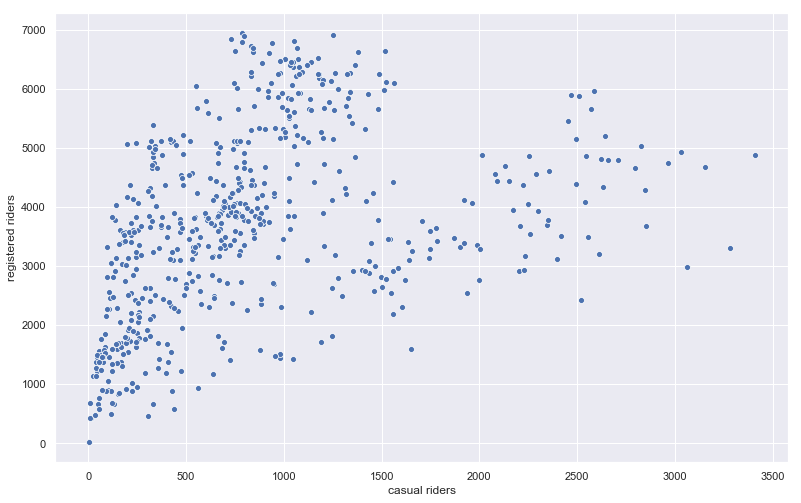

In [22]:
# example of scatter: plot the number of casual riders against registered riders
sns.scatterplot(x="casual riders", y="registered riders",
               data=bike_train);

As you might remember from Professor Kariv's videos in Module II, the shape of the scatter plot can give us some information about how two variables are **correlated**: what the value of one variable can or cannot tell you about the value of another.

<br/>

<div class="class alert-warning">
<b>EXERCISE:</b> Try plotting at least one numerical explanatory variable (temp, felt temp, windspeed, or humidity) against a response variable (casual, registered, or total riders). What would you say about the relationship between the two variables based on the scatter plot?
</div>

In [ ]:
# your code here
sns.scatterplot(x=..., y=...,
               data=bike_train);

You can also *overlay* two scatter plots on top of one another. This can be helpful when comparing multiple responser variables.

To overlay two scatter plots, give a list of columns as the second argument instead of a single column name. The following cell gives an example: try substituting in different column names to create different plots.

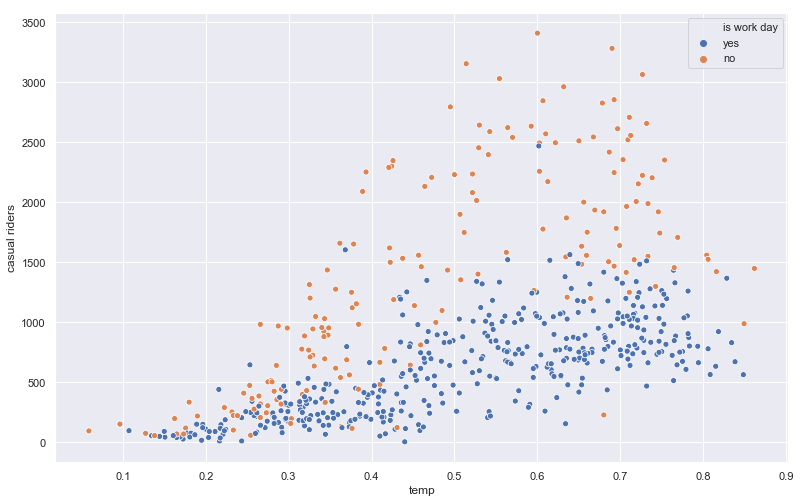

In [23]:
# plot date of the year against casual and total riders
sns.scatterplot(x="temp", y="casual riders",
               data=bike_train, hue="is work day");

In the following cell, we've created another widget to make it easier to compare multiple variables against one another.

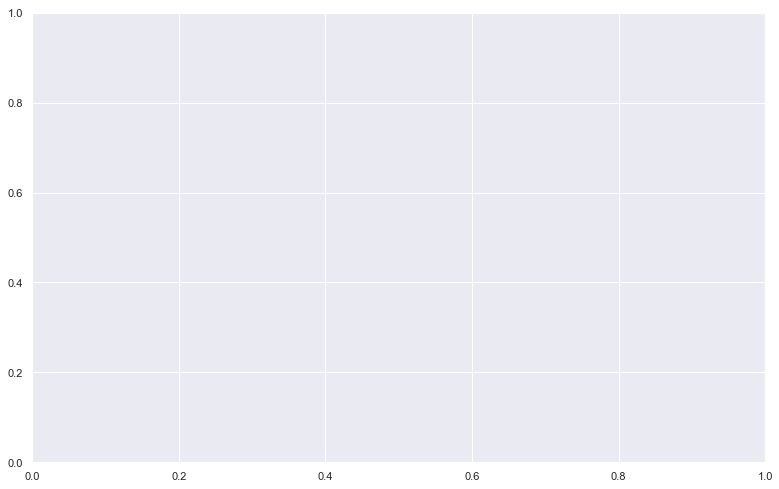

In [35]:
fig, ax = plt.subplots()
ax.legend()

In [41]:
# create a widget to make different scatter plots
explanatory_slider = widgets.Dropdown(options=["date", "temp", "felt temp", "humidity", "windspeed"])
def scatter_widget(var):
    sns.scatterplot(x=var, y="registered riders", data=bike_train,
                   label="registered riders")
    sns.scatterplot(x=var, y="casual riders", data=bike_train, 
                   label="casual riders")
    plt.legend()
    
widgets.interact(scatter_widget, var=explanatory_slider);

interactive(children=(Dropdown(description='var', options=('date', 'temp', 'felt temp', 'humidity', 'windspeed…

<function __main__.scatter_widget>

<div class="class alert-warning">
<b>QUESTION:</b> Based on the scatter plots, which variables appear to be linearly correlated with rider counts? Which variables appear to be non-linearly correlated or uncorrelated? Is the apparent correlation different for casual or registered riders?
</div>

**ANSWER:**

Finally, we want to visualize our categorical variables using bar graphs. Remember, for categorical variables we are grouping rows into the different possible categories (like the seven days of the week) and aggregating all the values in the group into a single value (in this case, taking the average). 

Run the next cell to create a widget for making the different bar plots.

interactive(children=(Dropdown(description='expl_var', options=('season', 'month', 'is holiday', 'day of week'…

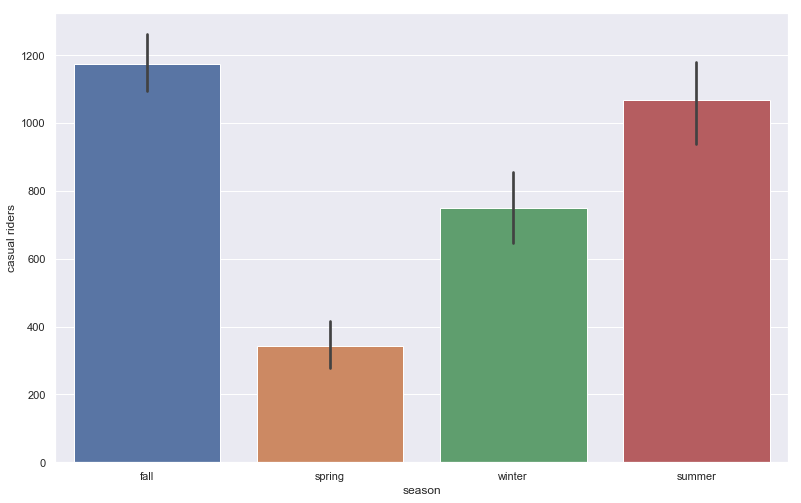

In [43]:
# define a function that groups by an explanatory variable and creates a horizontal bar graph
def barh_bikes(expl_var):
    sns.barplot(x=expl_var, y="casual riders", data=bike_train,
               label="casual riders")
    sns.barplot(x=expl_var, y="registered riders", data=bike_train,
           label="registered riders")
    plt.legend()

explanatory_slider = widgets.Dropdown(options=[ "season", "month", "is holiday", "day of week", "is work day",
                                            "weather"])
display(widgets.interactive(barh_bikes, expl_var=explanatory_slider))

<div class="class alert-warning">
<b>QUESTION:</b> Many of our categorical variables are related to time (e.g. week day, month, etc). How do usage patterns over time differ for registered and casual users? In what categories do the different user types act similarly?
</div>

**ANSWER:**

## 2. The Regression Model <a id= "section2"></a>

To try to predict the number of riders on a given day, we'll use a regression model. From Module II:

> A **simple regression model** describes how the conditional mean of a response variable $y$ depends on an explanatory variable $x$: $$\mu_{y|x} = \beta_0 + \beta_1x$$ This equation describes our best guess for $y$ given a particular  $x$.

> A **multiple regression model** describes how the conditional mean of a response variable $y$ depends on multiple explanatory variables $x_1, x_2, ..., x_k$: $$\mu_{y|x_1, x_2, ..., x_k} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_kx_k$$ This equation describes our best guess for $y$ given a particular vector $x_1, x_2, ..., x_k$.

In this case, our model will look something like this:
$$\mu_{\text{rider count}|\text{temp, humidity, ..., month}} = \beta_0 + \beta_1*\text{(temp)} + \beta_2*\text{(humidity)} + ... + \beta_k*\text{(month)}$$
The code for either a simple or multiple regression model is basically identical except for the number of columns we select for inclusion in our explanatory variables.

To create our model, we need to:
1. isolate the explanatory variables (X) and response variable (y) we want to use
2. find the values for the $\beta$ variables on the best-fit regression line
3. evaluate the accuracy of our model

### 2a. Explanatory and response variables <a id="subsection2a"></a>

First, let's decide on our response variable. We'll try to predict the *total number of riders* on a given day. The response variable needs to be in an array (not a Table), so we'll get it using the `column` function.

In [ ]:
# response variable: total count of riders in a day (training set)
y_train = bike_train.column('total riders')

# response variable: total count of riders in a day (validation set)
y_test = bike_test.column('total riders')

y_train

Next, we want to choose our explanatory variables. Let's try predicting ridership in terms of _temperature_, _work day_, and _season_.

<div class="alert alert-info">

**Why don't we just use all the explanatory variables?**
You might think that the best model would use *all* the available explanatory information. But, using many variables makes a model **computationally expensive**. In the real world, where data sets may have a million or more rows, using a complex model can increase the time and computing power needed to make preditions. Additionally, many variables may have **little predictive power** such that excluding them from the model doesn't lower the accuracy very much. Other variables might **add noise** that actually decreases the model's performance outside of the training data.

</div> 

Here, we run into a problem: "work day" and "season" are categorical variables (even though they have numerical values). This gets tricky with regression- the computer starts to work with the values as if they were numbers, and that can lead to questionable manipulations. For example, since Sunday is coded as 0 and Saturday is coded as 6, the computer might conclude that the average of Sunday and Saturday is Wednesday (since Wednesday is coded as 3).

#### One-Hot Encoding
To work around this, we will **one-hot encode** all our categorical variables. In one-hot encoding, the possible values of the variable each get their own column of 1s and 0s. The value is a 1 if that day falls in that category and a 0 otherwise.

Here's an example. Say we have three possible weather states: rain, cloudy, or sunny.

In [ ]:
categorical = Table().with_columns("weather", ["rainy", "cloudy", "sunny", "cloudy"])
categorical

The one-hot encoding would look like this:

In [ ]:
# pd.get_dummies is a function that does dummy encoding
one_hot = pd.get_dummies(categorical.column('weather'))
one_hot

Notice that in each row, only one of the values is equal to 1 (hence the name, "one-hot" encoding), since no day can have more than one weather state.

Notice also that we don't technically need the third column. 

In [ ]:
one_hot.drop("sunny", axis=1)

If we know that there are only three possible weather states, and we see that day 2 was neither cloudy nor rainy (that is, `cloudy`=0 and `rainy`=0), day 2 *must* have been sunny. This is helpful to save computation time and space. If you have some knowledge of linear algebra, note that this is also helpful to solve the problem of *perfect multicollinearity*- a situation that can make it impossible to compute the optimal set of $\beta$s.

For simplicity, we've provided a function called `format_X` that will take a Table of explanatory variables and convert it to the correct format for prediction, including one-hot encoding the categorical variables. `format_X` will also add a column called "intercept" that only contains 1s. This column will help find the intercept term $\beta_0$ in our regression line. You can think of the intercept term as an $x_0$ that gets multiplied by $\beta_0$ and is always equal to 1.

In [ ]:
# select the explanatory variables to use in a Table
expl_train = bike_train.select("temp", "is work day", "season")

# convert the explanatory table to the correct format
X_train = format_X(expl_train)

# show the first five rows of the model inputs
X_train.head()

<div class="class alert-warning">
<b>EXERCISE:</b> Since we want to try the model on the test data as well, we will also perform the same transformations on the test set so it can fit the model. Fill in the code to first select the explanatory variables "temp", "is work day", and "season", then convert the explanatory table to the matrix format using `format_X`. Hint: we'll need to go through the exact same steps as in the above cell for the training data, but any references to training data should be replaced by their test data counterparts.
</div>

In [ ]:
# select the explanatory variables to use in a Table
expl_test = ...

# convert the explanatory table to the correct format
X_test = ...

# show the first five rows of the model inputs
X_test.head()

### 2b.  Finding $\beta$ <a id="subsection2b"></a>
The next step is to calculate the $\beta$ terms. We can do this with a function from the Scipy statistical analysis Python package called `lstsq`.

Given a matrix of explanatory variables X and an array of response variables y, `lstsq` returns a vector $\beta$. `lstsq` uses *ordinary least squares* as its **loss function (L)**: the function that defines the training loss (error) and what we seek to minimize (often using linear algebra or calculus, depending on the loss function). The ordinary least squares equation is a common loss function that is used to minimize the sum of squared errors:

$$L(\beta) = \frac{1}{n}\sum_{n}^{i=1}(y_i - \text{predicted}(\beta, x_i))^2$$

where $n$ is the number of days, $y_i$ is the actual number of riders on the $i$th day, and $\text{predicted}(\beta, x_i)$ is number of riders predicted to be on the $i$th day when using $\beta$ and the explanatory variables $x_i$. When minimized, the loss function will yield our optimal $\beta$. 

`lstsq` returns a list of four things, but for our purposes we're only interested in one of them: the array of the $\beta$ values for the best-fit line.

In [ ]:
# calculate the least squares solution
lstsq_results = lstsq(X_train, y_train)

beta = lstsq_results[0]

beta

We now have everything we need to make predictions about the total number of riders on a given day. Remember, the formula is: $$\mu_{y|x_1, x_2, ..., x_k} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_kx_k$$

So, to make a prediction for a given day, we take all the values in the X matrix corresponding to that day, multiply each value by its corresponding $\beta$, then add them all together. The `@` operator can help us with this matrix multiplication.

For example, here's the first row of our explanatory variable matrix.

In [ ]:
X_train.loc[0:5, :]

To get the prediction, we use `@` to multiply each item in the row by each corresponding item in the $\beta$ vector and sum them all up. If you've taken linear algebra, you'll recognize this as the [*dot product*](https://en.wikipedia.org/wiki/Dot_product).

<img src="images/vector_mult.png" />



In [ ]:
# multiply the arrays to get the prediction
X_train.loc[0, :] @ beta

The `@` operator can also work on matrices. To get the predictions for *every* row in X, we use exactly the same syntax.

<img src="images/matrix_mult.png"  />


In [ ]:
predict_train = X_train @ beta
predict_train

Now we can add our predictions to our original table.

In [ ]:
bike_train.append_column("predicted total riders", predict_train)
bike_train

<div class="alert-warning">
    <b>EXERCISE:</b> We also want to make predictions for the test data using the $\beta$ we found during training. Replace the `...` in the cell below with an expression to calculate the predictions for the test set. Remember- you need to use `@` to multiply each row of explanatory variables in our test set by the $\beta$ vector. Look at how `predict_train` was calculated for a guide.
    </div>

In [ ]:
predict_test = ...
bike_test.append_column("predicted total riders", predict_test)
bike_test

### 2c. Evaluating the model <a id="subsection2c"></a>

Our model makes predictions, but how good are they? We can start to get a sense of how we did by plotting the predictions versus the actual values on our training data on a scatter plot. Remember from Module II that if our model predicts perfectly:

- the predicted values will be equal to the actual values
- all points in the scatter plot will fall along a straight line with a slope of 1

As a bonus, `scatter` has an optional argument called `fit_line` that will add the best-fit line to the plot if you mark it as `True`.

In [ ]:
bike_train.scatter("predicted total riders", "total riders", fit_line=True)
plt.title("Training set predictions");

Here are the validation set predictions scattered against the actual total rider counts. Note that we've added an extra `color` argument to `scatter` to change the color of the dots and line and distinguish the validation data from the training data.

In [ ]:
bike_test.scatter("predicted total riders", "total riders", fit_line=True, color=(1.0, 200/256, 44/256))
plt.title("Test set predictions");

We can also get a quantitative measure of how good our model is by calculating the **root mean squared error**. This is fairly straightforward to calculate now that we have our error vector:
1. subtract the predictions from the actual values to get the errors
2. square the errors
3. take the average of the squared errors
4. take the square root of the average squared error

In [ ]:
# the root mean squared error of the training data
errors = y_train - predict_train
sq_error = errors ** 2
mean_sq_error = np.average(sq_error)
root_mean_sq_err = np.sqrt(mean_sq_error)
root_mean_sq_err

<div class="alert alert-info">

**Why Root Mean Squared Error (RMSE)?**
To know why RMSE is useful, it helps to think about the steps to derive it in order. We *square* the errors to get rid of any negative signs (we don't care if we overpredict or underpredict, we just want to know the magnitude of the error). We then want the *average* magnitude of the error to see how far off our model typically was. Finally, we take the *square root* to get back to the original units (in this case, number of riders as opposed to squared number of riders).

</div> 

Next, we want to see what the RMSE is for our test set predictions. To simplify things, we have a function called `rmse` that takes a column of predicted values and a column of actual values and calculates the root mean squared error.

Before you run the next cell: would you expect the RMSE for the test set would be higher, lower, or about the same as the RMSE for the training set? Why?

In [ ]:
# the root mean squared error of the test data
rmse(y_test, predict_test)

We can also visualize our errors compared to the actual values on a scatter plot.

In [ ]:
bike_train.append_column("training error", errors)
bike_train.scatter("predicted total riders", "training error", fit_line=True)

In [ ]:
bike_test.append_column("validation error", y_test - predict_test)
bike_test.scatter("predicted total riders", "validation error", fit_line=True, color=(1.0, 200/256, 44/256))

<div class="alert-warning">
    <b>QUESTION:</b> Based on the plots and root mean squared error above, how well do you think our model is doing? What does the shape of the scatter plot of errors tell us about the appropriateness of the linear model here?
    </div>

**ANSWER:** 

## 3. Challenge: Improve the Model <a id="section3"></a>

Our model is currently not very good. But, there's a lot of things we could try to improve it.

In the following cells you have almost everything you need to create a new linear regression model. To try a new model, fill in the two sets of ellipses below:
- set `response` to the *string name* of the response variable you want to predict
- set `expl` to be a *list of string names of explanatory variables* you want to incorporate into the model. Remember, the names should be strings (i.e. in quotation marks) and separated by commas in between the square brackets.

Once you've filled in the ellipses, run all the cells below in order to recalculate the $\beta$ vector, make new predictions, and look at the residuals. A helpful tip: in the "Cell" menu at the top, clicking "Run All Below" will run all code cells below the cell you currently have selected.

How accurate can you make the model?

In [ ]:
# select a response variable: "casual", "registered", or "total riders"
response = ...

y_train = bike_train.column(response)
y_test = bike_test.column(response)

In [ ]:
# list the explanatory variables to use as strings separated by commas
expl = [...]

X_train = format_X(bike_train.select(expl))
X_test = format_X(bike_test.select(expl))

In [ ]:
# calculate the least squares solution
beta = lstsq(X_train, y_train)[0]

In [ ]:
# calculate predicted values
pred_train = X_train @ beta
bike_train.append_column("predicted {}".format(response), pred_train)
pred_test = X_test @ beta
bike_test.append_column("predicted {}".format(response), pred_test)


In [ ]:
# compare predictions to actual values on a scatter plot
bike_train.scatter("predicted {}".format(response), response, fit_line=True)
plt.title("Training set predictions");

In [ ]:
bike_test.scatter("predicted {}".format(response), response, fit_line=True, color=(1.0, 200/256, 44/256))
plt.title("Test set predictions");

In [ ]:
#calculate the root mean squared error
rmse_train = rmse(pred_train, y_train)
rmse_test = rmse(pred_test, y_test)
print("Training RMSE = {0}\nValidation RMSE = {1}".format(rmse_train, rmse_test))

In [ ]:
# plot the residuals on a scatter plot
bike_train.append_column("error", y_train - pred_train)
bike_train.scatter("predicted {}".format(response), "training error", fit_line=True)

In [ ]:
# plot the residuals on a scatter plot
bike_test.append_column("error", y_test - pred_test)
bike_test.scatter("predicted {}".format(response), "validation error", fit_line=True, color=(1.0, 200/256, 44/256))

<div class="class alert-warning">
<b>QUESTION:</b> What explanatory variables did you use in the best model you found? What metrics showed that it was the "best" model? Reference the scatter plots, fit lines, RMSE, etc.
</div>

**ANSWER:**

#### References
- Bike-Sharing data set from University of California Irvine's Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- Portions of text and code adapted from Professor Jonathan Marshall's Legal Studies 190 (Data, Prediction, and Law) course materials: [lab 2-22-18, Linear Regression](https://github.com/ds-modules/LEGALST-190/tree/master/labs/2-22) (Author Keeley Takimoto)  and [lab 3-22-18, Exploratory Data Analysis](https://github.com/ds-modules/LEGALST-190/tree/masterlabs/3-22) (Author Keeley Takimoto)
- "Capital Bikeshare, Washington, DC" header image by [Leeann Caferatta](https://www.flickr.com/photos/leeanncafferata/34309356871) licensed under [CC BY-ND 2.0](https://creativecommons.org/licenses/by-nd/2.0/)